In [1]:
%matplotlib inline


Time-domain photonic circuits
=============================

*Authors: Fabian Laudenbach, Josh Izaac, Theodor Isacsson and Nicolas
Quesada*

We introduce the basic ideas of time-domain photonic
systems together with the time-domain module of StrawberryFields,
``strawberryfields.tdm``. Time-domain multiplexing allows for the
creation of massive quantum systems having millions of entangled modes
as shown in a number of recent experimental demonstrations [1-4].
To motivate this architecture we follow Takeda et al. [1]  and
study the one loop setup shown in the picture below:

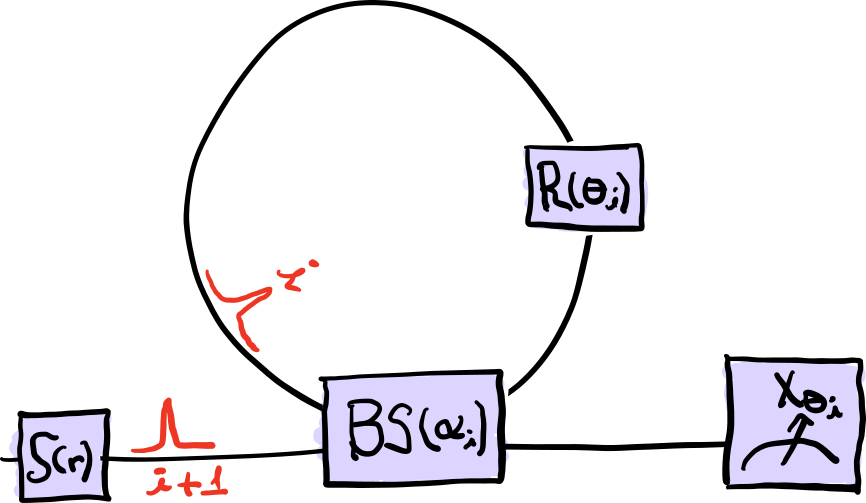

We will first write a short standard StrawberryFields program implementing
this. Then we will progressively modify the way this circuit is
implemented until we are able to write it directly as a [``TDMProgram``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.TDMProgram.html).

Having understood the basics of time-domain programs we will then construct a generic
single-loop function that can be used to simulate arbitrary long programs using only two
modes! We will use this machinery to investigate bipartite EPR states and then
multipartite GHZ states. An important take away of this tutorial is that one can sample
efficiently Gaussian circuits containing millions of modes with the equivalent
computation effort of sampling Gaussian circuits with just a handful of modes.

An instruction set for the time-domain architecture
---------------------------------------------------

To introduce the time domain architecture we will simulate the setup in
the figure. We can summarize the setup as the following set of
intructions:

1. The ``i+1`` mode is squeezed by a certain amount ``r``.
2. The ``i+1`` mode undergoes a beamsplitter transformation with its
   preceding mode, labeled by ``i``, by a certain angle ``alpha[i]``.
   This beamsplitter has the effect of switching in and out of the loop
   the modes ``i+1`` and ``i`` respectively.
3. The ``i+1`` mode has entered the loop after the beamsplitter
   transformation and is rotated by angle ``phi[i]``.
4. After interacting with the ``i+1`` mode, the mode in the previous
   time bin ``i`` leaves the loop and then its rotated quadrature (by angle
   ``theta[i]``) is measured using a homodyne detector.

This circuit falls within the time-domain description because we are
implicitly assuming that the modes are flying through the optical elements
(squeezer, beamsplitter, rotation, measurement) in the figure above.
Note that the loop in the figure corresponds physically to a delay line,
typically implemented using propagation in free space or in an optical fiber.
Thus unlike in many other physical implementations
our modes are not labeled by a position in space but by a time label that
tells us when they arrived to a particular optical element.

Before actually trying to take advantage of the time-domain description
of the circuit we will write a brute force simulation using the
standard [``Program``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.Program.html).

We will use ``n`` modes to represent ``n`` timebins and implement the
setup described by the figure using a standard StrawberryFields
program.

Since we will be using a Gaussian circuit this implies that we will be using
a covariance matrix of size ``2n`` times ``2n`` to represent our state. Thus,
if we have for example ``n=1000`` modes we will have on the order of four million
real numbers stored in memory. We will however, just stick to ``n=20`` for this
concrete example.




In [2]:
import strawberryfields as sf
from strawberryfields.ops import Sgate, BSgate, Rgate, MeasureHomodyne
import numpy as np

Below we assume that the parameters of the squeezing gate $(S)$
and the angles of the beamsplitter $(BS)$ and rotation $R$
do not change with the timebin.




In [3]:
# We set the seed to facilitate later comparison
# since the samples are stochastic.
np.random.seed(42)
n = 20

r = 1.0
length = n - 1
alpha = [np.pi / 4] * length
phi = [0] * length
theta = [0] * length

prog0 = sf.Program(n)
with prog0.context as q:
    for i in range(n - 1):
        Sgate(r) | q[i + 1]
        BSgate(alpha[i]) | (q[i], q[i + 1])
        Rgate(phi[i]) | q[i + 1]
        MeasureHomodyne(theta[i]) | q[i]
eng0 = sf.Engine("gaussian")
result0 = eng0.run(prog0)

We can look at an unrolled version of the program above in terms of
a circuit diagram as

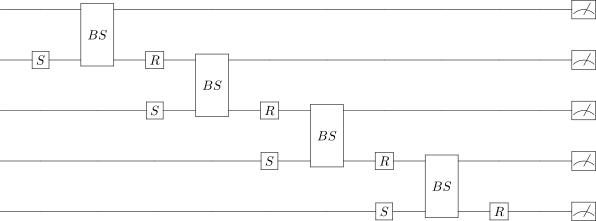

where, for clarity, we have reduced the number of displayed modes to ``n=5``.

Finally, we can also look at the samples:

In [4]:
print(result0.samples)

[[-0.10417347  0.60228311 -0.00316101  0.34561221  0.25296546 -0.13280689
  -0.67985316 -0.19192785  0.12600941 -0.51235116 -0.07813559 -0.52072239
   0.04318271  0.13989725 -0.10611505  0.68226231 -0.38850925 -0.44870008
  -0.72062428]]


In this program we follow each and every time-bin mode (a total of
``n=20`` modes) as they progress through the different operations.
However, at most only two modes are interacting at the same time. The
rest of the modes either have not been squeezed (and thus are in the
vacuum state) or have been measured (and thus reset to vacuum).

Reducing simulation resources: shifting modes
-----------------------------------------------

Instead of keeping track of the modes using labels telling us their time
bin, we can label them in terms of the position that they occupy in the
circuit above. A convenient choice of labels is to look at the two modes
that enter into the beamsplitter. We can use ``0`` for the mode that
enters in the top port of the beamsplitter and which has been
circulating in the loop. We can use the label ``1`` for the mode that
has just been squeezed and is about to enter the beamsplitter in the
bottom port. These two modes, which have fixed positions in the circuit,
we call concurrent modes; they are, at all times, the only two modes
that are not in vacuum in the circuit.

To make a closed loop of modes going in and out of the circuit one can
recycle the mode that is measured (mode ``0``) and plug it back in as a
vacuum mode re-entering the circuit. As it turns out the Gaussian
backend of Strawberry Fields automatically resets to vacuum a mode that
has been measured thus the resetting is automatically taken care of.

To implement the recycling we will need a function that takes the mode
that is measured (which sits at the  beginning of the mode list ``q``)
and moves it back to the end of the list after it is measured.
This functionality is
provided by the function ``shift_by`` in the module
``strawberryfield.tdm.tdmprogram`` as illustrated below:




In [5]:
from strawberryfields.tdm.program import shift_by

l = [0, 1, 2, 3, 4]
shift_by(l, 1)

[1, 2, 3, 4, 0]

We are now ready to simulate an ``n=20`` mode circuit using only two
concurrent modes:




In [6]:
np.random.seed(42)  # We set the seed to facilitate comparison
prog1 = sf.Program(2)
n = 20
with prog1.context as q:
    for i in range(n - 1):
        Sgate(r) | q[1]
        BSgate(alpha[i]) | (q[0], q[1])
        Rgate(phi[i]) | q[1]
        MeasureHomodyne(theta[i]) | q[0]
        # Note that only position 0 of q is measured
        q = shift_by(q, 1)
eng1 = sf.Engine("gaussian")
result1 = eng1.run(prog1)
print(result1.samples)

[[-0.72062428 -0.44870008]]


Even though we measured ``n-1`` times we only get 2 values. This is
because the ``samples`` attribute only contains the last ever measured
value(s) in our modes; since we only have two concurrent modes we only get
two numbers. To obtain the complete sample record we use the attribute
``samples_dict``, which contains all measured samples inside of a dict.




In [7]:
print(result1.samples_dict)

{0: [array([-0.10417347]), array([-0.00316101]), array([0.25296546]), array([-0.67985316]), array([0.12600941]), array([-0.07813559]), array([0.04318271]), array([-0.10611505]), array([-0.38850925]), array([-0.72062428])], 1: [array([0.60228311]), array([0.34561221]), array([-0.13280689]), array([-0.19192785]), array([-0.51235116]), array([-0.52072239]), array([0.13989725]), array([0.68226231]), array([-0.44870008])]}


Note that we obtain the same samples as in ``result0.samples`` except
that they are ordered in a slightly different arrangement. We can put
them in the correct order by using ``reshape_samples``




In [8]:
from strawberryfields.tdm.program import reshape_samples

reshape_samples(result1.samples_dict, [0], [2], n - 1)

{0: array([[-0.10417347,  0.60228311, -0.00316101,  0.34561221,  0.25296546,
         -0.13280689, -0.67985316, -0.19192785,  0.12600941, -0.51235116,
         -0.07813559, -0.52072239,  0.04318271,  0.13989725, -0.10611505,
          0.68226231, -0.38850925, -0.44870008, -0.72062428]])}

The second argument ``[0]`` gives the label of the
concurrent mode where a measurement happened,
while the third argument ``[2]`` indicates, for this simple one loop program,
that there are only two concurrent modes in a single loop.
Finally, the last argument gives the information on the number of
time bins measured. Notice that it is ``n-1`` and not ``n``.



All the measurement outcomes are now attached to the only mode
that we ever measured, namely ``0``. Note that in ``result1.samples_dict``
the samples are attached to different modes. This is an artifact of the
recycling.




By recycling the modes we are now able to simulate very long circuits
with just two modes. Going back to our hypothetical one thousand mode example,
we would need to keep in memory millions of real numbers, instead by using
a time-domain strategy where we only worry about concurrent modes we only ever
need to consider covariances matrices of size four by four, which results
in massive speed and memory gains!


The TDMProgram
----------------

Rather than performing the mode shifting and sample reshaping manually,
Strawberry Fields provides the [``TDMProgram``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.TDMProgram.html) program class for automating this procedure, making it easy to construct and simulate time-domain multiplexing algorithms.

In this class one needs to specify the number of
active modes (``N=2`` for the example above) and then the class takes
care of automatically shifting the modes and reshaping the samples. Thus
the program above could have been rewritten as




In [9]:
np.random.seed(42)  # We set the seed to facilitate comparison
N = 2  # Number of concurrent modes
prog2 = sf.TDMProgram(N=N)

with prog2.context(alpha, phi, theta) as (p, q):
    Sgate(r, 0) | q[1]
    BSgate(p[0]) | (q[0], q[1])
    Rgate(p[1]) | q[1]
    MeasureHomodyne(p[2]) | q[0]
eng2 = sf.Engine("gaussian")
result2 = eng2.run(prog2)
print(result2.samples)

[[[-0.10417347  0.60228311 -0.00316101  0.34561221  0.25296546
   -0.13280689 -0.67985316 -0.19192785  0.12600941 -0.51235116
   -0.07813559 -0.52072239  0.04318271  0.13989725 -0.10611505
    0.68226231 -0.38850925 -0.44870008 -0.72062428]]]


In a ``TDMProgram`` we need to specify the number of concurrent modes
``N``. Then we pass to the ``context`` the sequences of
the different parameters that will be used in the program, in our case
the lists ``alpha``, ``phi`` and ``theta``. The three variables in the
list ``p`` will cycle through the corresponding values of these lists.
For example, ``p[0]`` will go through the values of ``alpha`` as the
simulation progresses.




A single-loop architecture
--------------------------

We will now write a simple function that
encapsulates the single loop architecture using a ``TDMprogram``. Then we
will use it to generate samples of interesting quantum states and
investigate their correlations.




In [10]:
def singleloop(r, alpha, phi, theta, shots):
    """Single loop program.

    Args:
        r (float): squeezing parameter
        alpha (Sequence[float]): beamsplitter angles
        phi (Sequence[float]): rotation angles
        theta (Sequence[float]): homodyne measurement angles
        shots (int): number of times the circuit is sampled
    Returns:
        list: homodyne samples from the single loop simulation
    """

    prog = sf.TDMProgram(N=2)
    with prog.context(alpha, phi, theta) as (p, q):
        Sgate(r, 0) | q[1]
        BSgate(p[0]) | (q[0], q[1])
        Rgate(p[1]) | q[1]
        MeasureHomodyne(p[2]) | q[0]
    eng = sf.Engine("gaussian")
    result = eng.run(prog, shots=shots)
    # We only want the samples from concurrent mode 0
    return result.samples_dict[0]

We can use the function we just developed to reproduce for the fourth
time the results of our very simple experiment:




In [11]:
np.random.seed(42)  # We set the seed to facilitate comparison
singleloop(r, alpha, phi, theta, 1)  # We want 1 shot

array([[-0.10417347,  0.60228311, -0.00316101,  0.34561221,  0.25296546,
        -0.13280689, -0.67985316, -0.19192785,  0.12600941, -0.51235116,
        -0.07813559, -0.52072239,  0.04318271,  0.13989725, -0.10611505,
         0.68226231, -0.38850925, -0.44870008, -0.72062428]])

Generation of EPR states
------------------------

With the single loop architecture we can easily generate
Einstein-Podolsky-Rosen (EPR) states [5]. In this section we will create
this bipartite state and probe it using homodyne measurements.




In [12]:
r = 2.0
alpha = [np.pi / 4, 0]
phi = [0, np.pi / 2]
theta = [0, 0]  # We will measure the positions by setting theta = [0,0]
shots = 2500

samplesEPRxx = singleloop(r, alpha, phi, theta, shots)

To process the samples we simply transpose the array in which they
are stored. This gives us easier access to the values corresponding
to the two halves of an EPR state.



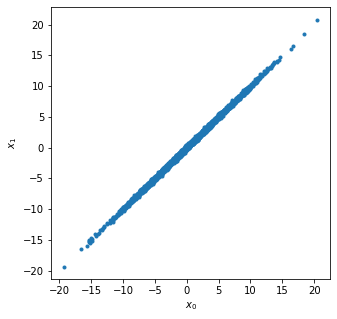

In [13]:
samplesxx = samplesEPRxx.T
x0 = samplesxx[0]
x1 = samplesxx[1]

# We now want to look at the samples
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.plot(x0, x1, ".")
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_{1}$")
plt.show()

We can put this observation in more quantitative terms by looking at the
variance of $x_1-x_0$:




In [14]:
sample_var_xx = np.var(x0 - x1)
sample_var_xx

0.036501533171290304

As it turns out the variance of the operator $N_1 = x_1 - x_0$ is
related to the amount of squeezing used to prepare the state. One can
easily find that $\text{Var}(N_1) = 2 e^{-2 r}$.




In [15]:
expected_var_xx = 2 * np.exp(-2 * r)
expected_var_xx

0.03663127777746836

In the literature, the operator $N$ for which one finds a relation
like the one above, is called a *Nullifier* of the state. A way to
understand this name is that the variance of this operator approaches
zero (or *nullifies*) as the squeezing in the state grows [1].




The EPR state has a second nullifier, $N_2 = p_1+p_2$. We can
confirm this by running our circuit again, but this time measuring
in the $P$ quadrature




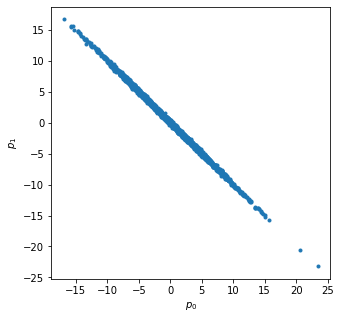

In [16]:
theta = [np.pi / 2, np.pi / 2]  # Now we homodyne the p-quadratures by setting thr angle to pi/2
samplesEPRpp = singleloop(r, alpha, phi, theta, shots)

samplespp = samplesEPRpp.T
p0 = samplespp[0]
p1 = samplespp[1]

plt.figure(figsize=(5, 5))
plt.plot(p0, p1, ".")
plt.xlabel(r"$p_0$")
plt.ylabel(r"$p_{1}$")
plt.show()

We now calculate the sample variance and the expected variance,
except for the effect of finite size statistics, they are almost identical




In [17]:
np.var(p0 + p1), 2 * np.exp(-2 * r)

(0.03548400449860628, 0.03663127777746836)

Generating GHZ states
-----------------------

The GHZ states (named after Greenberger, Horne and Zeilinger) [6] can be
thought as an $n$-partite generalization of the EPR states [7]. We
will prepare these states using the single loop architecture
encapsulated in the function ``singleloop`` defined before.




In [18]:
n = 10
vac_modes = 1  # This is an ancilla mode that is used at the beginning of the protocol
shots = 1
r = 4
alpha = [np.arccos(np.sqrt(1 / (n - i + 1))) if i != n + 1 else 0 for i in range(n + vac_modes)]
alpha[0] = 0.0
phi = [0] * (n + vac_modes)
phi[0] = np.pi / 2
theta = [0] * (n + vac_modes)  # We will measure first all the states in the X quadrature

singleloop(r, alpha, phi, theta, shots)

array([[-1.52220534, -1.23988693, -1.26801579, -1.23267925, -1.26416284,
        -1.2843186 , -1.26506774, -1.28691118, -1.24585304, -1.23932062,
        -1.2995661 ]])

Note that all the *sampled* positions are the
same. We can also sample our state in the $p$ basis




In [19]:
theta = [np.pi / 2] * (n + vac_modes)  # Now we measure in p quadrature

samplep = singleloop(r, alpha, phi, theta, shots)
samplep

array([[ -0.52960821,  29.02743432, -93.3646886 ,  32.95431112,
        -39.99464345,  45.80328279, -52.37852011,  59.10381464,
         -8.2737421 ,   7.31907984,  19.76999235]])

There does not seem to be anything interesting going on when we look at
the $p$ quadratures, yet if we consider the sum of the sampled
values of the momenta we find that the momenta add up to approximately
zero:




In [20]:
np.sum(samplep[1:])  # Note that we exclude the first element, the "vacuum mode"

0.0

Indeed, like for the EPR state defined before, one can introduce
nullifiers for the GHZ states such as
$N_k = x_k - x_n$ for $1 \leq k < n$,




We now generate many samples and statistically verify that the variances
of the nullifier decay exponentially with the amount of squeezing




In [21]:
# Collect x-samples
shots = 1000
theta = [0] * (n + vac_modes)
samplesGHZx = singleloop(r, alpha, phi, theta, shots)

nullifier_X = lambda sample: (sample - sample[-1])[vac_modes:-1]
val_nullifier_X = np.var([nullifier_X(x) for x in samplesGHZx], axis=0)

The sample variances of the X nullifiers are



In [22]:
val_nullifier_X

array([0.00068616, 0.00066431, 0.00066148, 0.00068736, 0.00064939,
       0.00071838, 0.00067035, 0.00068083, 0.00066421])

While their expected value is



In [23]:
2 * np.exp(-2 * r)

0.0006709252558050237

Conclusion and final remarks
----------------------------
We have introduced the basic ideas of time-domain circuits by gradually
transforming a simple one-loop ``n``-mode optical setup from a brute
force simulator to a time-domain simulator using the [``TDMProgram``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.TDMProgram.html).
Using the later class we achieve significant computational savings: a brute force
Gaussian simulator requires resources scaling quadratically with the number of modes,
a time-domain approach requires only constant (and very modest) resources.
We have used this highly efficient implementation to study the correlations
of EPR and GHZ states, the canonical bipartite and multipartite entangled
states in the continuous-variable domain.



References
----------

[1]    S. Takeda, T. Kan and A. Furusawa. On-demand photonic entanglement synthesizer.
    Science Advances, 2019. doi:10.1126/sciadv.aaw4530 .

[2]    J. Yoshikawa, S. Yokoyama, T. Kaji, C. Sornphiphatphong, Y. Shiozawa, K. Makino and A. Furusawa.
    Generation of one-million-mode continuous-variable cluster state by unlimited time-domain multiplexing.
    APL Photonics, 2016. doi:10.1063/1.4962732 .

[3]    M. V. Larsen, X. Guo, C. R. Breum, J. S. Neergaard-Nielsen and U. L. Andersen.
    Deterministic generation of a two-dimensional cluster state.
    Science, 2019. doi:10.1126/science.aay4354 .

[4]    W.Asavanant, Y. Shiozawa, S. Yokoyama, B. Charoensombutamon, H. Emura, R. N. Alexander, S. Takeda, J. Yoshikawa, N. C. Menicucci, H. Yonezawa and A. Furusawa. Generation of time-domain-multiplexed two-dimensional cluster state. Science, 2019. doi:10.1126/science.aay2645 .

[5]    A. Einstein, B. Podolsky and N. Rosen. Can quantum-mechanical description of physical reality be considered complete? Physical Review, 1935. doi:10.1103/PhysRev.47.777 .

[6]    D. M. Greenberger, M. A. Horne and A. Zeilinger. Going beyond Bell's Theorem. arXiv:0712.0921, 2007.

[7]    P. van Loock, S. L. Braunstein. Multipartite Entanglement for Continuous Variables: A Quantum Teleportation Network. Physical Review Letters, 2000. doi:10.1103/PhysRevLett.84.3482 .

